# Notebook to train the model on the UrbanSound8K dataset

In [1]:
# import libraries and set random seed for reproducibility
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import gc

from matplotlib import pyplot as plt
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator

tf.keras.utils.set_random_seed(42)
np.random.seed(42)

In [2]:
# allow memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# load the dataframe containing the metadata
train_data = pd.read_csv('metadata/UrbanSound8K.csv')

# edit the path of the images in the dataframe
for i in range(len(train_data)):
    pre = 'images' + os.sep + 'fold' + str(train_data['fold'][i]) + os.sep
    train_data.at[i, 'slice_file_name'] = pre + train_data.at[i, 'slice_file_name'] + '.png'
    
train_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,images\fold5\100032-3-0-0.wav.png,100032,0.0,0.317551,1,5,3,dog_bark
1,images\fold5\100263-2-0-117.wav.png,100263,58.5,62.500000,1,5,2,children_playing
2,images\fold5\100263-2-0-121.wav.png,100263,60.5,64.500000,1,5,2,children_playing
3,images\fold5\100263-2-0-126.wav.png,100263,63.0,67.000000,1,5,2,children_playing
4,images\fold5\100263-2-0-137.wav.png,100263,68.5,72.500000,1,5,2,children_playing


## Hyperparameters

In [4]:
# Define the number of folds
k = 10

# Define the number of epochs for each fold
epochs = 2

# Define the batch size. It depends on your GPU
batch_size = 8

## Parameters

In [5]:
# Define the target image size
height = 450
width = 450
channels = 3
target_size = (height, width)
target_shape = (height, width, channels)

# Define the class mode
class_mode = 'categorical'

# Define the data generator for data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             fill_mode='nearest')

# Define the list of all image labels
labels = train_data['class'].unique()

# Convert the labels to a numpy array
labels = np.array(labels)

# Define the number of classes
num_classes = len(labels)
print('Number of classes:', num_classes)

Number of classes: 10


## Model

In [6]:
# Define and compile the model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=target_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

tf.keras.backend.clear_session()
gc.collect()
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 446, 446, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 223, 223, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 219, 219, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 109, 109, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 53, 53, 128)      0

## Train the model with k-fold cross validation

In [7]:
# Define a dictionary to store the history of the model for each fold
fold2history = {}

tf.config.run_functions_eagerly(False)

# Start the k-cross fold cross validation
for fold in range(k):
    fold += 1
    
    # Define the model
    model = create_model()
    
    # Define the training and validation dataframes for this fold 
    train_df = train_data[train_data['fold'] != fold]
    test_df = train_data[train_data['fold'] == fold]

    histories = []
    
    for fold_val in range(k):
        fold_val += 1
        # Doesn't train on the test set
        if fold_val == fold:
            continue
        
        train = train_df[train_df['fold'] != fold_val]
        val = train_df[train_df['fold'] == fold_val]
        
        # Define the directories for training and validation data
        train_datagen = datagen.flow_from_dataframe(
            dataframe=train,
            directory=None,
            x_col='slice_file_name',
            y_col='class',
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode)
    
        # Define the data generator for validation data
        val_datagen = datagen.flow_from_dataframe(
            dataframe=val,
            directory=None,
            x_col='slice_file_name',
            y_col='class',
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode)
        
        clear_output(wait=True)
        print(f'Testing with fold{fold}, Validating with fold{fold_val}')
        
        # Train the model on the training data
        history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, verbose=1)
        histories.append(history.history)
        
        del history, train, val, train_datagen, val_datagen
        
    
    test_datagen = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col='slice_file_name',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)
    
    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(test_datagen)
    print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')
    
    # Save the history of the model for each fold
    fold2history[fold] = (histories, loss, accuracy)
    
    # Save the model for each fold
    model.save('models'+ os.sep +f'fold{fold}_model.h5')
    
    # Delete the model to free memory on GPU
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    gc.collect()
    del model, train_df, test_df, histories, test_datagen, loss, accuracy

Testing with fold10, Validating with fold9
Epoch 1/2
885/885 [==============================] - 81s 92ms/step - loss: 0.0073 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/2
885/885 [==============================] - 82s 92ms/step - loss: 0.0020 - accuracy: 0.9980 - val_loss: 0.0010 - val_accuracy: 1.0000
Found 837 validated image filenames belonging to 10 classes.
105/105 [==============================] - 8s 76ms/step - loss: 0.5653 - accuracy: 0.6571
Test loss: 0.5653, Test accuracy: 0.6571


## Results and plots

In [8]:
history = []
test_loss = []
test_accuracy = []

for fold in fold2history.keys():
    for i in range(0,9):
        history.extend(fold2history[fold][0][i]['val_accuracy'])
    test_loss.append(fold2history[fold][1])
    test_accuracy.append(fold2history[fold][2])

In [9]:
# get the fold with the highest accuracy
best_fold = np.argmax(test_accuracy) + 1

# copy the model to the best_model.h5 file
shutil.copyfile('models'+ os.sep +f'fold{best_fold}_model.h5', 'models'+ os.sep +'best_model.h5')

print(f'Best fold: {best_fold}, Test loss: {test_loss[best_fold-1]:.4f}, Test accuracy: {test_accuracy[best_fold-1]:.4f}')

Best fold: 9, Test loss: 0.9075, Test accuracy: 0.6887


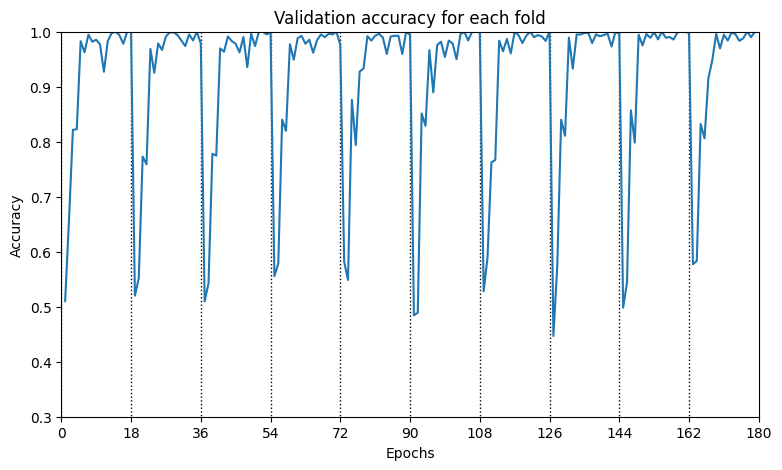

In [10]:
# validation accuracy for each fold
plt.figure(figsize=(9, 5))
plt.title('Validation accuracy for each fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([1, len(history), 0.3, 1])

# draw dot lines for each fold
for i in range(k):
    plt.plot([i*(k-1)*epochs, i*(k-1)*epochs], [0, 1], 'k:', linewidth=1)
    
plt.xticks(np.arange(0, len(history)+1, (k-1)*epochs))
plt.plot(np.arange(1, len(history)+1), history, label='val accuracy')

plt.show()

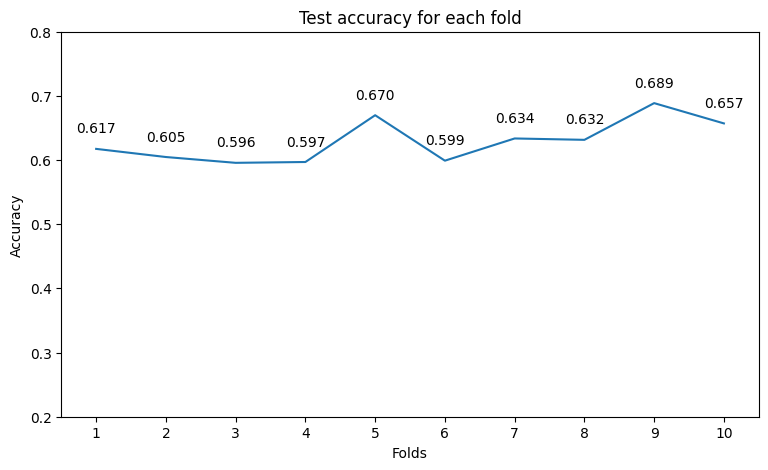

In [11]:
# test accuracy plot
plt.figure(figsize=(9, 5))
plt.title('Test accuracy for each fold')
plt.xlabel('Folds')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([0.5, len(test_accuracy)+0.5, 0.2, 0.8])

for i, v in enumerate(test_accuracy):
    plt.text(i+1, v+0.025, "%.3f" %v, ha="center")
 
plt.xticks(np.arange(1, len(test_accuracy)+1, 1))   
plt.plot(np.arange(1, len(test_accuracy)+1), test_accuracy, label='test accuracy')

plt.show()

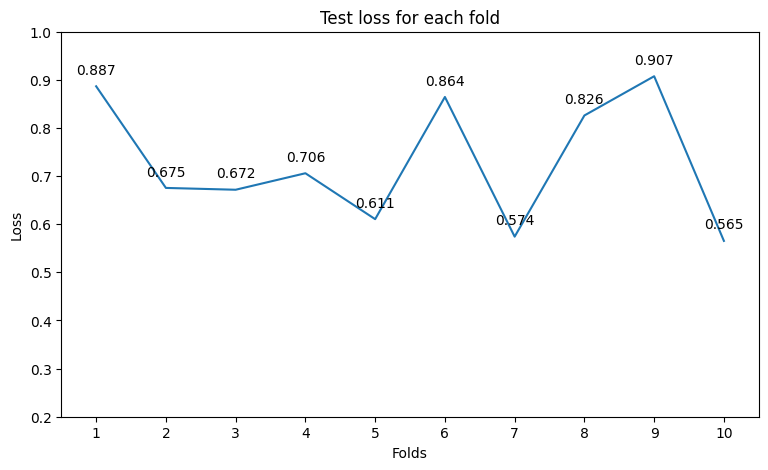

In [12]:
# test loss plot
plt.figure(figsize=(9, 5))
plt.title('Test loss for each fold')
plt.xlabel('Folds')
plt.ylabel('Loss')

# set axis limits to show the plot clearly
plt.axis([0.5, len(test_loss)+0.5, 0.2, 1])

for i, v in enumerate(test_loss):
    plt.text(i+1, v+0.025, "%.3f" %v, ha="center")
 
plt.xticks(np.arange(1, len(test_loss)+1, 1))   
plt.plot(np.arange(1, len(test_loss)+1), test_loss, label='test loss')

plt.show()